In [1]:
import tensorflow as tf
from tensorflow.keras import models , layers
import matplotlib.pyplot as plt
import numpy as np

In [24]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 4

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
  "train/train" ,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 5657 files belonging to 5 classes.


In [5]:
class_name = dataset.class_names
print(class_name)
n_class = len(class_name)

['cbb', 'cbsd', 'cgm', 'cmd', 'healthy']


In [6]:
len(dataset)

177

In [7]:
for img_batch, label_batch in dataset.take(1):
    print(img_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[2 0 3 3 3 3 3 2 3 3 1 3 0 3 1 3 1 1 3 4 3 4 2 1 3 1 3 2 2 3 3 1]


2024-11-19 15:05:49.105129: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(256, 256, 3)
(256, 256, 3)
(256, 256, 3)
(256, 256, 3)


2024-11-19 15:05:49.959133: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


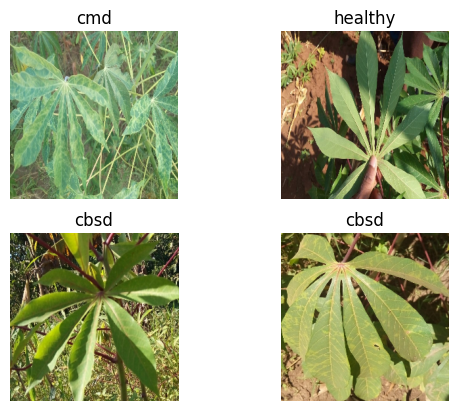

In [8]:
for img_batch, label_batch in dataset.take(1):
    for i in range(4):
        ax = plt.subplot(2,2,i+1)
        print(img_batch[i].shape)
        plt.imshow(img_batch[i].numpy().astype("uint8"))
        plt.title(class_name[label_batch[i]])
        plt.axis('off')

## Spliting the data into train and test

In [10]:
train_size = 0.8
val_size = 0.2
n_train = int(train_size*len(dataset))
n_val = int(val_size*len(dataset))
print(n_train)
print(n_val)

141
35


In [11]:
train_ds = dataset.take(n_train)
test_ds = dataset.skip(n_train)
print(f'train size : {len(train_ds)}')
print(f'test size : {len(test_ds)}')

train size : 141
test size : 36


In [12]:
val_ds = test_ds.take(n_val)
test_ds = test_ds.skip(n_val)

In [13]:
def get_data_partitions_tf(ds, train_split = train_size, val_split=val_size,shuffle=True,shuffle_size = 10000):

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
    
    n_train = int(train_size*ds_size)
    n_val = int(val_size*ds_size)
    
    train_ds = ds.take(n_train)
    test_ds = ds.skip(n_train)

    val_ds = test_ds.take(n_val)
    test_ds = test_ds.skip(n_val)
    
    return train_ds, val_ds,test_ds

In [14]:
train_ds, val_ds, test_ds = get_data_partitions_tf(dataset)

In [15]:
len(train_ds)

141

In [16]:
len(val_ds)

35

In [17]:
len(test_ds)

1

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Preprocessing

In [19]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [20]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

## Building Models

In [21]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = len(class_name)

In [22]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
])

model.build(input_shape=input_shape)

/Users/BabouMbaye/PycharmProjects/EndToEndVison/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [23]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 5)                │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,877 (718.27 KB)

 Trainable params: 183,877 (718.27 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/4
141/141 ━━━━━━━━━━━━━━━━━━━━ 91s 617ms/step - accuracy: 0.4573 - loss: 1.3621 - val_accuracy: 0.5625 - val_loss: 1.2157
Epoch 2/4
141/141 ━━━━━━━━━━━━━━━━━━━━ 83s 590ms/step - accuracy: 0.5509 - loss: 1.2392 - val_accuracy: 0.4902 - val_loss: 1.3489
Epoch 3/4
141/141 ━━━━━━━━━━━━━━━━━━━━ 81s 573ms/step - accuracy: 0.5511 - loss: 1.2192 - val_accuracy: 0.5482 - val_loss: 1.2436
Epoch 4/4
141/141 ━━━━━━━━━━━━━━━━━━━━ 81s 577ms/step - accuracy: 0.5828 - loss: 1.1582 - val_accuracy: 0.5670 - val_loss: 1.1777


In [28]:
scores = model.evaluate(test_ds)
scores

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.5625 - loss: 1.1651


[1.1650726795196533, 0.5625]

In [29]:
history

In [56]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 141}

In [57]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Losses')

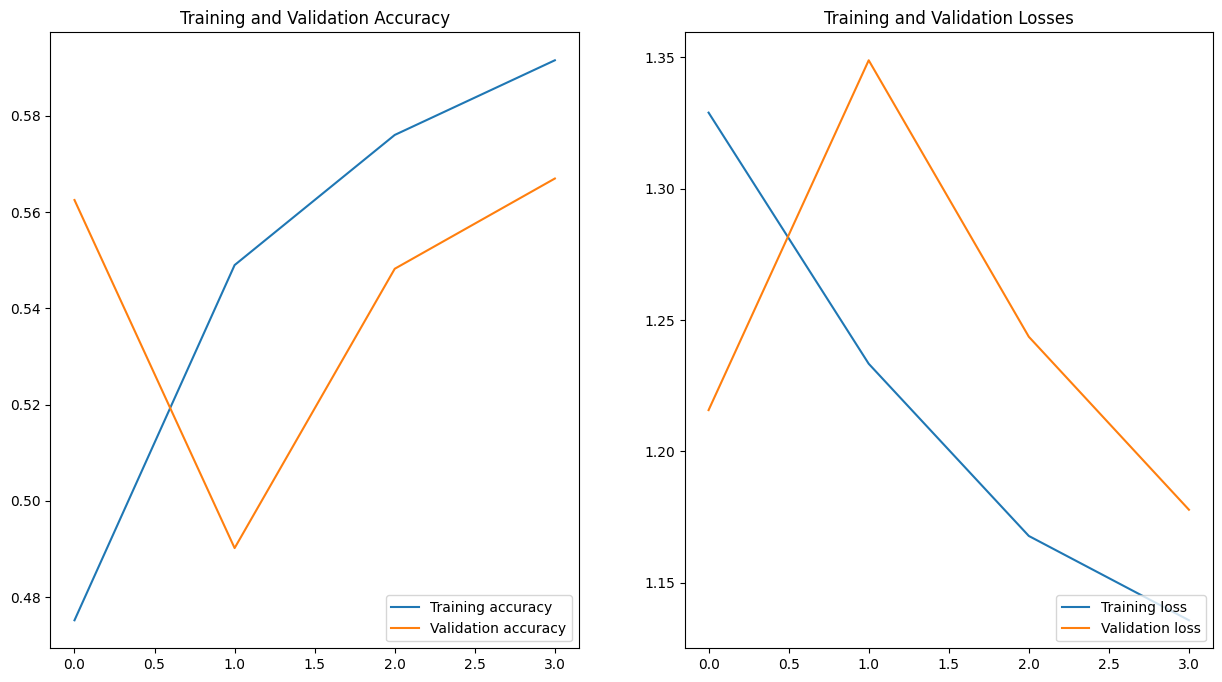

In [31]:
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training loss')
plt.plot(range(EPOCHS), val_loss, label='Validation loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Losses')

first image to predict
actual label: cmd
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
Predicted label: cmd


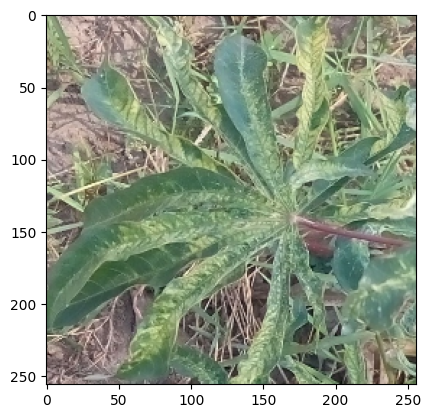

In [32]:
for image_batch, labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

print("first image to predict")
plt.imshow(first_image)
print(f"actual label: {class_name[first_label]}")

batch_prediction = model.predict(image_batch)
print(f"Predicted label: {class_name[np.argmax(batch_prediction[0])]}")

In [42]:
print(batch_prediction[0])
class_name[np.argmax(batch_prediction[0])]

[0.02832047 0.07711461 0.17436717 0.68189216 0.03830548]


'cmd'

In [92]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array,0)

    predictions = model.predict(img_array)

    predicted_class = class_name[np.argmax(predictions[0])]
    confidence = round(100*np.max(predictions[0]),2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


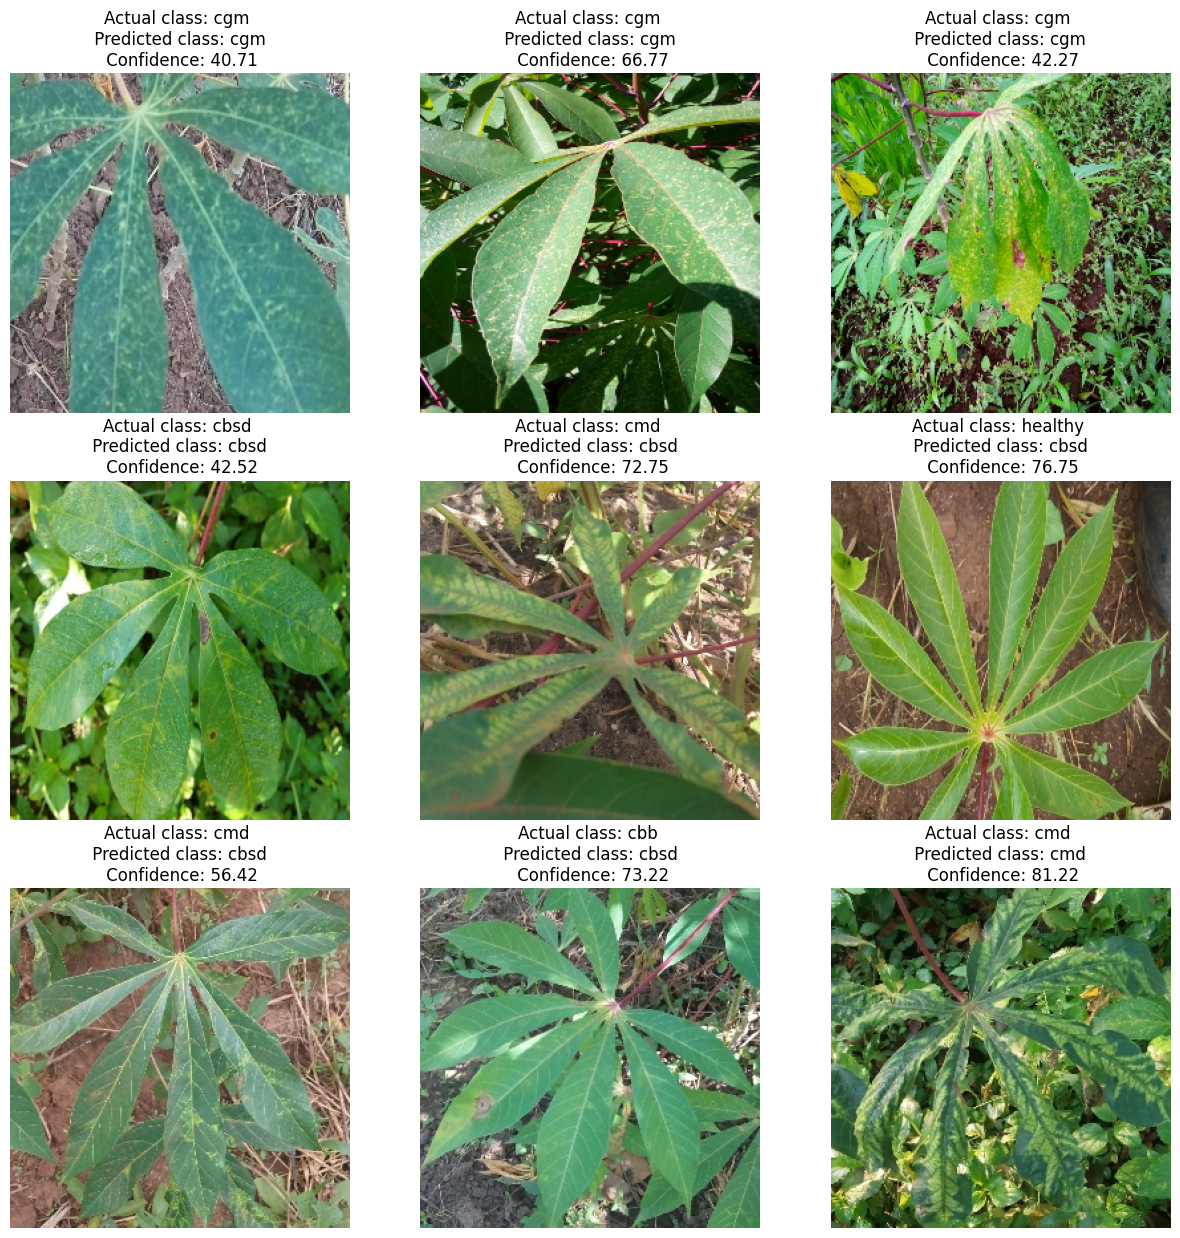

In [93]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_name[labels[i]]

        plt.title(f'Actual class: {actual_class} \n Predicted class: {predicted_class} \n Confidence: {confidence}' )
        plt.axis('off')
        

In [97]:
model_version = 'version_1'
model.save('saved_models/version_1.keras')
model.save('saved_models/version_1.h5')
model.export('saved_models/version_1')


INFO:tensorflow:Assets written to: models/version_1/assets


INFO:tensorflow:Assets written to: models/version_1/assets


Saved artifact at 'models/version_1'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  13289504400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13289496720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6323933200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6323934544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6323933584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6323936080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6323934928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6323936464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6323935888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6323936848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6323936656: TensorSpec(shape=(), dtype=tf.resource, name=None)